In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My\ Drive/McGill/AML/FinalProj/WGAN_RMS

/content/drive/My Drive/McGill/AML/FinalProj/WGAN_RMS


In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
import pickle

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


In [0]:
class WGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.losses = {"D_real":[], "D_fake":[] ,"G":[]}


        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))
            self.losses["D_real"].append(d_loss[0])
            self.losses["D_fake"].append(d_loss[1])
            self.losses["G"].append(g_loss)
            with open('WGAN_RMS.pickle', 'wb') as handle:
              pickle.dump(self.losses, handle, protocol=pickle.HIGHEST_PROTOCOL)
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
        self.plot_loss()

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./images/wgan%d.png" % epoch)
        plt.close()
        
        
    def plot_loss(self):
        d_loss = [v for v in self.losses["D_real"]]
        g_loss = [v for v in self.losses["G"]]
        #d_acc = [v[1] for v in losses["D"]]
        #g_acc = [v[1] for v in losses["G"]]

        plt.figure(figsize=(10,8))
        plt.plot(d_loss, label="Discriminator loss")
        plt.plot(g_loss, label="Generator loss")
        #plt.plot(d_acc, label="Discriminator accuracy")
        #plt.plot(g_acc, label="Generator accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('WGAN RMS')
        plt.legend()
        plt.savefig("./WGAN_rms_loss.png")
        plt.show()

   


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_1

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999931] [G loss: 1.000157]
1 [D loss: 0.999936] [G loss: 1.000151]
2 [D loss: 0.999936] [G loss: 1.000148]
3 [D loss: 0.999935] [G loss: 1.000152]
4 [D loss: 0.999930] [G loss: 1.000144]
5 [D loss: 0.999934] [G loss: 1.000149]
6 [D loss: 0.999930] [G loss: 1.000159]
7 [D loss: 0.999933] [G loss: 1.000151]
8 [D loss: 0.999927] [G loss: 1.000144]
9 [D loss: 0.999937] [G loss: 1.000143]
10 [D loss: 0.999939] [G loss: 1.000136]
11 [D loss: 0.999931] [G loss: 1.000153]
12 [D loss: 0.999943] [G loss: 1.000137]
13 [D loss: 0.999936] [G loss: 1.000146]
14 [D loss: 0.999936] [G loss: 1.000144]
15 [D loss: 0.999936] [G loss: 1.000133]
16 [D loss: 0.999936] [G loss: 1.000132]
17 [D loss: 0.999949] [G loss: 1.000116]
18 [D loss: 0.999942] [G loss: 1.000114]
19 [D loss: 0.999938] [G loss: 1.000114]
20 [D loss: 0.999944] [G loss: 1.000119]
21 [D loss: 0.999944] [G loss: 1.000103]
22 [D loss: 0.999954] [G loss: 1.000110]
23 [D loss: 0.999950] [G loss: 1.000101]
24 [D loss: 0.999952] [G l

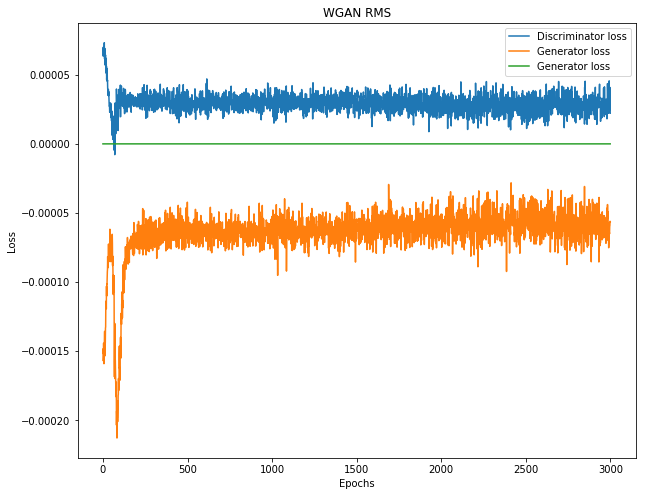

In [0]:
wgan = WGAN()
wgan.train(epochs= 3000, batch_size = 32, sample_interval = 50)